In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Capstone

/content/drive/MyDrive/Capstone


In [ ]:
#!unzip '/content/drive/MyDrive/Capstone/dataset-jenis-sampah-20220526T130506Z-001.zip' -d '/content/drive/MyDrive/Capstone/Data'

In [3]:
#Creating Function to Converting size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [4]:
#Creating Function to Getting file size

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras import Model
from keras.models import load_model

Found 8539 files belonging to 9 classes.


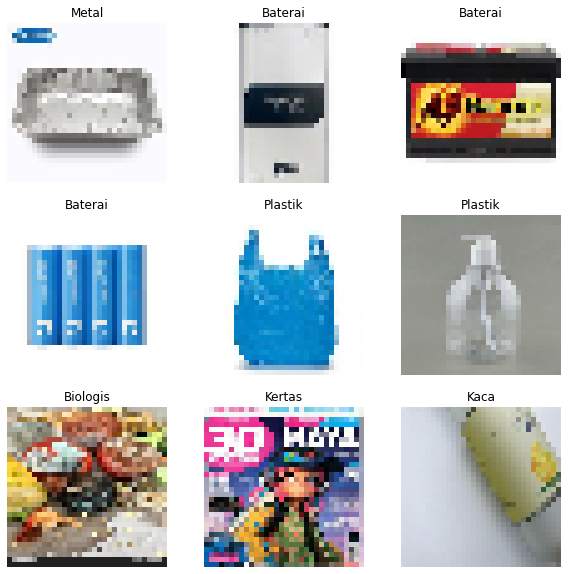

In [6]:
img_height, img_width = 32, 32
batch_size = 20

data = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/Capstone/Data/dataset-jenis-sampah",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
class_name = ['Baterai', 'Biologis', 'Kaca', 'Kain', 'Kardus', 'Kertas', 'Metal', 'Plastik', 'Sepatu']
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [7]:
d = pd.DataFrame()
directory = "/content/drive/MyDrive/Capstone/Data/dataset-jenis-sampah/"

for name in os.listdir(directory):
  temp = pd.DataFrame()
  temp['dir'] = np.nan
  temp['target'] = name
  i = 0
  for image in os.listdir(directory + name):
    temp.loc[i, 'dir'] = directory+name+ "/" + image
    temp.loc[i, 'name'] = name+ "/" + image
    temp.loc[i, 'target'] = name
    i += 1
  d = pd.concat([d, temp], ignore_index=True)
  del temp


data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
train_data, val_data = train_test_split(d, test_size=0.1, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

len(train_data), len(val_data), len(test_data)

(7685, 427, 427)

In [8]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 7685 validated image filenames belonging to 9 classes.


In [9]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    seed=42)

Found 427 validated image filenames belonging to 9 classes.


In [10]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=directory,
    x_col='name',
    y_col='target',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=42)

Found 427 validated image filenames belonging to 9 classes.


In [11]:
base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3),
)
out = base.output
out = Flatten()(out)
out = Dense(100, activation='relu')(out)
result = Dense(len(class_name),
            activation = 'softmax',
            kernel_initializer = 'random_uniform'
            )(out)
model = Model(
    inputs = base.input,
    outputs = result
)

for layer in base.layers:
    layer.trainable=False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, restore_best_weights='True', patience=20)

train_samples = train_generator.samples // 64
validation_samples = val_generator.samples // 64
model.fit(
    train_generator,
    steps_per_epoch=train_samples,
    epochs=30,
    batch_size=64,
    validation_data=val_generator,
    callbacks=callback,
    verbose = 1,
    validation_steps=validation_samples)

Epoch 1/30
120/120 [==============================] - 1482s 12s/step - loss: 0.3520 - accuracy: 0.8914 - val_loss: 0.1924 - val_accuracy: 0.9453
Epoch 2/30
120/120 [==============================] - 394s 3s/step - loss: 0.0497 - accuracy: 0.9861 - val_loss: 0.2118 - val_accuracy: 0.9453
Epoch 3/30
120/120 [==============================] - 394s 3s/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.2277 - val_accuracy: 0.9453
Epoch 4/30
120/120 [==============================] - 398s 3s/step - loss: 0.0201 - accuracy: 0.9950 - val_loss: 0.2140 - val_accuracy: 0.9557
Epoch 5/30
120/120 [==============================] - 409s 3s/step - loss: 0.0213 - accuracy: 0.9940 - val_loss: 0.2884 - val_accuracy: 0.9427
Epoch 6/30
120/120 [==============================] - 418s 3s/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.2830 - val_accuracy: 0.9505
Epoch 7/30
120/120 [==============================] - 411s 3s/step - loss: 0.0463 - accuracy: 0.9892 - val_loss: 0.6971 - val_accuracy: 0.90

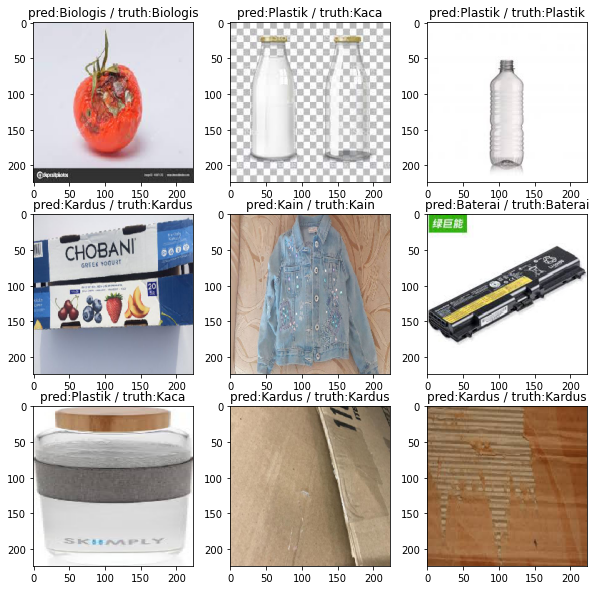

In [14]:
test_x, test_y = val_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_x[i].astype('uint8'))
    plt.title('pred:%s / truth:%s' % (class_name[np.argmax(preds[i])], class_name[np.argmax(test_y[i])]))

# Creating TF.Lite Model

In [15]:
#Saving from CNN model

model.save('/content/drive/MyDrive/Capstone/model/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/model/assets


In [16]:
#Load the Model

model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/model/')

In [17]:
#Creating name for the new model

tf_model = "tf_lite_model.tflite"

In [18]:
#Convert from existing model into tf.lite

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqav6wxqk/assets


In [19]:
#Writing the new tf.lite model

tflite_model_name = tf_model
open(tflite_model_name, "wb").write(tflite_model)

41118232

In [20]:
#Seeing the size of the model

convert_bytes(get_file_size(tf_model), "KB")

File size: 40154.523 Kilobytes


In [21]:
#Getting more infomartion about model

interpreter = tf.lite.Interpreter(model_path = tf_model)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 9]
Output Type: <class 'numpy.float32'>
